In [3]:
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from tqdm.notebook import tqdm

sys.path.insert(0, os.path.expanduser('~/openandn'))
device = 'cuda:2'
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
mnist_dataset_dir = 'mnist'

# MNIST preparation

In [4]:
mnist_train_dataset = torchvision.datasets.MNIST(
    mnist_dataset_dir, train=True, download=True
)
mnist_test_dataset = torchvision.datasets.MNIST(
    mnist_dataset_dir, train=False, download=True
)
mnist_train_data_device = mnist_train_dataset.data.to(device=device).to(dtype=torch.float32) / 255
mnist_test_data_device = mnist_test_dataset.data.to(device=device).to(dtype=torch.float32) / 255
mnist_train_targets_device = mnist_train_dataset.targets.to(device=device)
mnist_test_targets_device = mnist_test_dataset.targets.to(device=device)

#### For sparse input use following:

In [ ]:
from openandn.util.sparsify import NearestPointSparsifier
mnist_dataset_dir = 'mnist'

intensity_levels_dim_h = 4
intensity_levels_dim_w = 4
input_modules_distribution = torch.tensor([[1, 1, 2, 2], [2, 3, 3, 3], [3, 4, 4, 4], [4, 4, 4, 4]], dtype=torch.int32)
treat_zero_as_zero = False
sparsify_transform = NearestPointSparsifier(
    n_channels=-1,
    per_pixel_modules_distribution=input_modules_distribution,
    sparsifying_rules=[
        (0, 1, [1.0], False),
        (0, 2, [1.0 / 2, 1.0], False),
        (0, 3, [1.0 / 3, 2.0 / 3, 1.0], False),
        (0, 4, [1.0 / 6, 2.0 / 6, 3.0 / 6, 4.0 / 6, 5.0 / 6, 1.0], False)
    ],
    do_center=False
)

input_modules_shape = (intensity_levels_dim_h, intensity_levels_dim_w)

In [ ]:
from andn.util.sparsify import prepare_sparsify_transform_and_input_modules_distribution

gradient_example = torch.arange(256).reshape(16, 16) / 255
sparsified_gradient_example = sparsify_transform(gradient_example.unsqueeze(0))
reverse_gradient = sparsify_transform.reverse(sparsified_gradient_example)
gradient_img = to_pil_image(gradient_example).resize([256, 256], Image.NEAREST)
sparse_gradient_img = to_pil_image(sparsified_gradient_example).resize([256, 256], Image.NEAREST)
reverse_gradient_img = to_pil_image(reverse_gradient).resize([256, 256], Image.NEAREST)
dst = Image.new('RGB', (768, 256))
dst.paste(gradient_img, (0, 0))
dst.paste(sparse_gradient_img, (256, 0))
dst.paste(reverse_gradient_img, (512, 0))
dst

In [ ]:
input_modules_distribution

In [ ]:
mnist_train_dataset = TensorDataset(
    sparsify_transform(mnist_train_data_device).to(dtype=torch.float32), mnist_train_targets_device
)
mnist_test_dataset = TensorDataset(
    sparsify_transform(mnist_test_data_device).to(dtype=torch.float32), mnist_test_targets_device
)
sparsify_transform.set_use_cache(True)
def reverse_sparsify_transform(x):
    return sparsify_transform.reverse(x)

#### For dense input use following:

In [5]:
intensity_levels_dim_h = 1
intensity_levels_dim_w = 1
input_modules_shape = (intensity_levels_dim_h, intensity_levels_dim_w)

In [6]:
mnist_train_dataset = TensorDataset(
    mnist_train_data_device, mnist_train_targets_device
)
mnist_test_dataset = TensorDataset(
    mnist_test_data_device, mnist_test_targets_device
)
def reverse_sparsify_transform(x):
    return x

### Checking input, just in case

In [7]:
mnist_test_loader = torch.utils.data.DataLoader(
    mnist_test_dataset,
    batch_size=1, shuffle=True
)

example_data, example_targets = next(iter(mnist_test_loader))
to_pil_image(example_data)

In [8]:
example_data, example_targets

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [268]:
import torch
from dataclasses import dataclass


@dataclass(frozen=True, order=True)
class WTAClassifierConfiguration:
    noise_level: float = 0.5
    lr: float = 0.05
    classifier_lr: float = 0.01
    initial_bias: float = 1.0
    feedback_cf: float = 0.2
    constant_feedback: float = 0.0
    do_input_normalization: bool = True
    do_weights_normalization: bool = True
    temperature: float = 0.0
    temperature_decay: float = 0.9999

    def __post_init__(self):
        assert 0.0 <= self.noise_level <= 1.0
        assert 0.0 <= self.lr <= 1.0
        assert 0.0 <= self.classifier_lr <= 1.0
        assert 0.0 <= self.initial_bias
        assert 0.0 >= self.constant_feedback
        assert 0.0 <= self.temperature <= 1.0
        assert 0.0 <= self.temperature_decay <= 1.0


class WTAClassifier(object):
    def __init__(
        self, n_inputs, n_clusters, n_classes,
        configuration: WTAClassifierConfiguration
    ):
        self._n_inputs = n_inputs
        self._n_clusters = n_clusters
        self._n_classes = n_classes
        self._configuration = configuration
        self._temperature = self._configuration.temperature

        self._clustering_weights = torch.ones([n_clusters, n_inputs], dtype=torch.float32)
        self._clustering_weights[:, :] -= torch.rand(
            [n_clusters, n_inputs], dtype=torch.float32
        ) * (2 * self._configuration.noise_level)
        if self._configuration.do_weights_normalization:
            self._clustering_weights /= self._clustering_weights.norm(dim=-1, keepdim=True)
        self._classifier_weights = torch.ones([n_classes, n_clusters], dtype=torch.float32)
        self._classifier_weights[:, :] -= torch.rand(
            [n_classes, n_clusters], dtype=torch.float32
        )
        if self._configuration.constant_feedback < 0.0:
            self._inverse_classifier_weights = torch.full([n_clusters, n_classes], self._configuration.constant_feedback)
            clusters_per_class = (n_clusters + (n_classes - 1)) // n_classes
            cluster_idx = 0
            for c in range(n_classes):
                for _ in range(clusters_per_class):
                    if cluster_idx == n_clusters:
                        break
                    self._inverse_classifier_weights[cluster_idx, c] = 0.0
                    cluster_idx += 1
        else:
            self._inverse_classifier_weights = torch.ones([n_clusters, n_classes], dtype=torch.float32)

        self._clustering_bias = torch.ones([n_clusters], dtype=torch.float32) * self._configuration.initial_bias
        self._winners_stats = torch.zeros([n_clusters], dtype=torch.int32)

    def n_inputs(self):
        return self._n_inputs

    def n_clusters(self):
        return self._n_clusters

    def n_classes(self):
        return self._n_classes

    def get_device(self):
        return self._clustering_weights.device

    def to_device(self, device):
        self._clustering_weights = self._clustering_weights.to(device=device)
        self._classifier_weights = self._classifier_weights.to(device=device)
        self._inverse_classifier_weights = self._inverse_classifier_weights.to(device=device)
        self._clustering_bias = self._clustering_bias.to(device=device)
        self._winners_stats = self._winners_stats.to(device=device)

    def train(self, data, gt):
        with (torch.no_grad()):
            xb = data.reshape([data.shape[0], self._n_inputs])
            gtb = gt.reshape([gt.shape[0], self._n_classes])
            if self._configuration.do_input_normalization:
                xb = xb / (xb.norm(dim=-1, keepdim=True) + 1e-08)

            u = torch.matmul(xb, self._clustering_weights.permute(1, 0))
            biased_u = u + self._clustering_bias

            if self._configuration.feedback_cf > 0.0:
                inverse_prediction = gtb @ self._inverse_classifier_weights.T
                winners = torch.argmax(biased_u + self._configuration.feedback_cf * inverse_prediction, dim=-1, keepdim=True)
            else:
                winners = torch.argmax(biased_u, dim=-1, keepdim=True)

            y_k = torch.zeros([data.shape[0], self._n_clusters], device=xb.device)
            y_k.scatter_(1, winners, 1.0)

            if self._configuration.feedback_cf > 0.0 and self._configuration.constant_feedback == 0.0:
                inverse_d = gtb.unsqueeze(1) - self._inverse_classifier_weights
                inverse_delta_w = (inverse_d * y_k.unsqueeze(2)).sum(dim=0)
                self._inverse_classifier_weights += inverse_delta_w * self._configuration.lr

            prediction = y_k @ self._classifier_weights.T
            grad_classifier = prediction - gtb
            classifier_delta_w = -(grad_classifier.T @ y_k)
            self._classifier_weights += classifier_delta_w * self._configuration.classifier_lr

            self._winners_stats += y_k.sum(dim=0).to(dtype=torch.int32)
            if self._temperature > 1e-08:
                quasi_grad = -torch.softmax(u / self._temperature, dim=-1)
                quasi_grad.scatter_(1, winners, 1.0)
                self._temperature *= self._configuration.temperature_decay
            else:
                quasi_grad = y_k

            clustering_delta_w = (
                (quasi_grad * y_k).unsqueeze(2) * (xb.unsqueeze(1) - self._clustering_weights) +
                (quasi_grad * (1 - y_k)).unsqueeze(2) * (0.0 - self._clustering_weights)
            ).sum(dim=0)
            
            delta_b = (
                quasi_grad * (y_k * (0.0 - self._clustering_bias) + (1 - y_k) * (self._clustering_bias - self._configuration.initial_bias))
            ).sum(dim=0)

            self._clustering_weights += self._configuration.lr * clustering_delta_w
            if self._configuration.do_weights_normalization:
                self._clustering_weights /= self._clustering_weights.norm(dim=-1, keepdim=True)
            self._clustering_bias += delta_b * self._configuration.lr
            return biased_u, y_k

    def classify(self, data, use_bias=True):
        with torch.no_grad():
            xb = data.reshape([data.shape[0], self._n_inputs])
            if self._configuration.do_input_normalization:
                xb = xb / (xb.norm(dim=-1, keepdim=True) + 1e-08)

            u = torch.matmul(xb, self._clustering_weights.permute(1, 0))
            if use_bias:
                biased_u = u + self._clustering_bias
            else:
                biased_u = u

            winners = torch.argmax(biased_u, dim=-1, keepdim=True)
            y_k = torch.zeros([data.shape[0], self._n_clusters], device=xb.device)
            y_k.scatter_(1, winners, 1.0)
            prediction = y_k @ self._classifier_weights.T
            return y_k, prediction

    def get_winners_stats(self):
        return self._winners_stats

    def get_cluster_weights(self):
        with torch.no_grad():
            return self._clustering_weights.clone()


def measure_classifier_accuracy(
        classifier, data_loader, max_samples=None, discard_bias=False
):
    hits = 0.0
    total = 0.0
    for batch_idx, (source_data, gt) in enumerate(data_loader):
        gt_one_hot = torch.nn.functional.one_hot(gt, num_classes=10).to(dtype=torch.float32).cpu().detach()
        _, prediction = classifier.classify(source_data, not discard_bias)
        prediction_one_hot = torch.nn.functional.one_hot(prediction.max(dim=-1)[1], num_classes=10).to(
            dtype=torch.float32).cpu().detach()
        hits += float(torch.all(gt_one_hot == prediction_one_hot, dim=1).sum().item())
        total += source_data.shape[0]
        if max_samples is not None and total >= max_samples:
            break

    return hits / total

In [375]:
clustering_dim = 44
img_size = 28
input_shape = [
    img_size * intensity_levels_dim_h,
    img_size * intensity_levels_dim_w
]

wta_classifier = WTAClassifier(
    n_inputs=input_shape[0] * input_shape[1],
    n_clusters=clustering_dim**2,
    n_classes=10,
    configuration=WTAClassifierConfiguration(
        lr=0.1,
        classifier_lr=0.01,
        initial_bias=1.0,
        feedback_cf=1.0,
        do_weights_normalization=True,
        do_input_normalization=True,
        temperature=1.0,
        temperature_decay=0.999
    )
)
wta_classifier.to_device(device)

In [382]:
from tqdm.notebook import tqdm

n_samples_per_epoch = len(mnist_train_dataset)
n_epochs = 8
batch_size = 8
pbar = tqdm(total=n_samples_per_epoch)
wta_classifier._winners_stats = torch.zeros([wta_classifier.n_clusters()], dtype=torch.int32, device=device)
for epoch in range(n_epochs):
    mnist_train_loader = torch.utils.data.DataLoader(
        mnist_train_dataset, batch_size=batch_size, shuffle=True
    )
    pbar.reset()
    pbar.set_description(f'Train Epoch: {epoch + 1}/{n_epochs}')
    for data, gt in mnist_train_loader:
        one_hot_gt = torch.nn.functional.one_hot(gt, num_classes=10).to(dtype=torch.float32, device=device)
        wta_classifier.train(data, one_hot_gt)
        pbar.update(data.shape[0])
        if pbar.n >= n_samples_per_epoch:
            break
pbar.close()

  0%|          | 0/60000 [00:00<?, ?it/s]

In [377]:
wta_classifier._clustering_bias.max(), wta_classifier._clustering_bias.mean(), wta_classifier._temperature

(tensor(0.0080, device='cuda:2'),
 tensor(1.3640e-05, device='cuda:2'),
 9.994687431792325e-09)

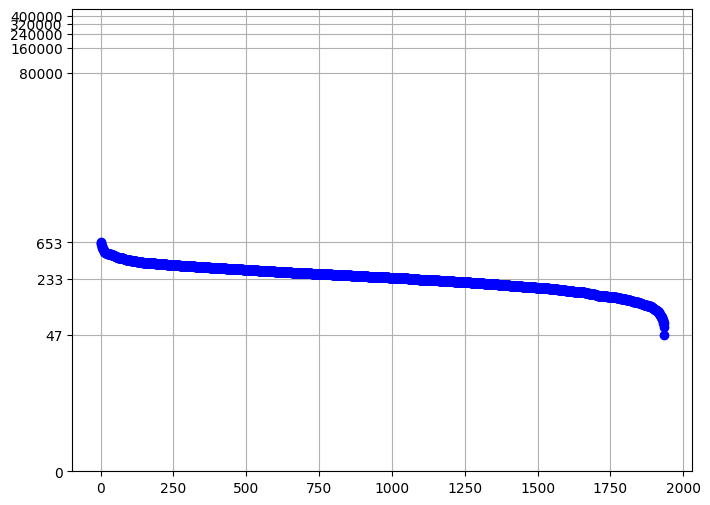

In [378]:
import matplotlib.pyplot as plt
import numpy as np
plt.close()

data = -np.sort(-wta_classifier.get_winners_stats().cpu().numpy())
max_y = data.sum()
data = np.log(1.0 + data)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(data, marker='o', linestyle='-', color='b', label="Winners distribution")
ax.grid(True)
ax.set_ylim(0, np.log(max_y + 1))
yticks = np.array(sorted(list(np.log(np.arange(0, 6) * (max_y / 6) + 1)) + [np.mean(data), np.min(data), np.max(data)]))
ax.set_yticks(yticks, [f'{int(v - 1)}' for v in np.exp(yticks).round()])
fig.show()

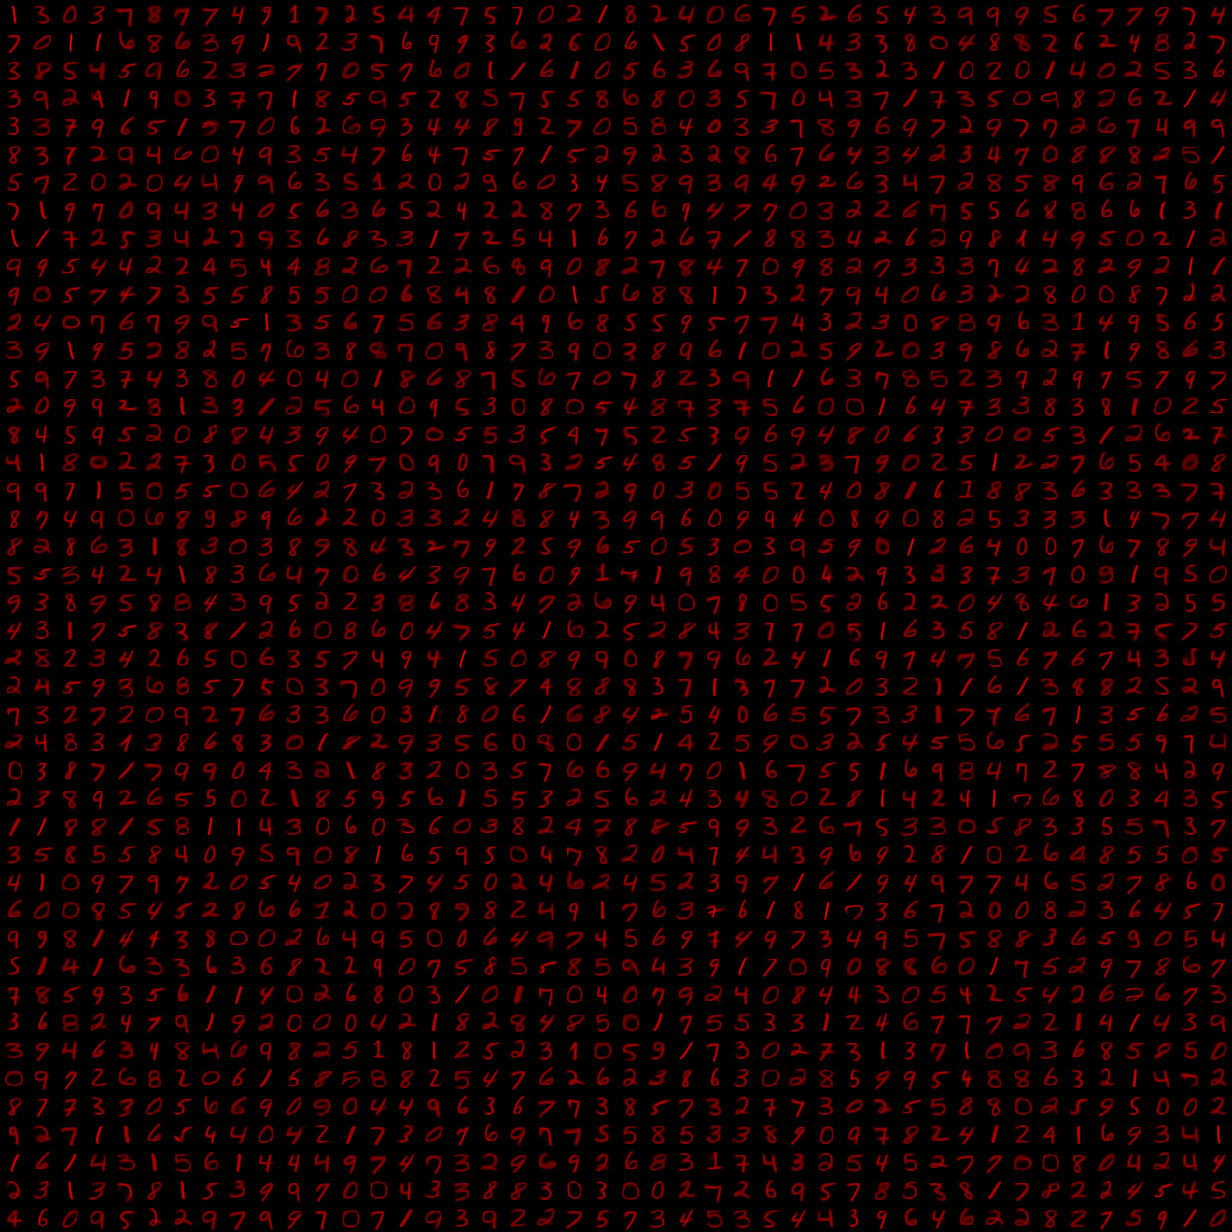

In [379]:
from andn.util.andn_visual_helpers import grayscale_to_red_and_blue
target_image = torch.zeros([clustering_dim * (img_size + 2), clustering_dim * (img_size + 2)])
weights = wta_classifier.get_cluster_weights()
weights /= weights.abs().max()
#weights = weights.sign()

for i in range(clustering_dim):
    for j in range(clustering_dim):
        target_image[
            i * (img_size + 2) + 1:i * (img_size + 2) + img_size + 1,
            j * (img_size + 2) + 1:j * (img_size + 2) + img_size + 1
        ] = reverse_sparsify_transform(weights[i*clustering_dim+j].reshape(img_size * intensity_levels_dim_h, img_size * intensity_levels_dim_w).unsqueeze(0))

img = grayscale_to_red_and_blue(target_image.unsqueeze(0))
color_rescaler = 1.0 / (img.abs().max() + 0.0000000001)
img = to_pil_image(img * color_rescaler)
img.resize(
    [clustering_dim * 28, clustering_dim * 28], Image.NEAREST
)

In [380]:
acc_train = measure_classifier_accuracy(
    wta_classifier, torch.utils.data.DataLoader(
        mnist_train_dataset, batch_size=512, shuffle=True
    ), discard_bias=False
)
acc_test = measure_classifier_accuracy(
    wta_classifier, torch.utils.data.DataLoader(
        mnist_test_dataset, batch_size=512, shuffle=True
    ), discard_bias=False
)
acc_train, acc_test

(0.9858333333333333, 0.9685)

In [381]:
from openandn.util.train_assistant import WTAClusteriserMeasureAccuracyByVotingAction

class WTAClassifierAsWTAClusteriser(object):
    def __init__(self, wta_classifier):
        self._wta_classifier = wta_classifier

    def get_device(self):
        return self._wta_classifier.get_device()

    def n_clusters(self):
        return self._wta_classifier.n_clusters()

    def clusterize(self, data, use_bias):
        res, _ = self._wta_classifier.classify(data, use_bias)
        return res.reshape([data.shape[0], self.n_clusters()]), None

measure_accuracy_action = WTAClusteriserMeasureAccuracyByVotingAction(
    10, mnist_test_dataset, mnist_train_dataset, use_bias=False, batch_size=512
)
acc_train, acc_test, predicted_labels = measure_accuracy_action(
    WTAClassifierAsWTAClusteriser(wta_classifier)
)
acc_train, acc_test

(0.9858333333333333, 0.9685)

## Backprop approach

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim

import random
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

train_bs = 64 # train batch size
test_bs = 1000 # test batch size
lr = 0.0001 # learning rate
gamma = 1.0 # decay

num_tasks = 10 # number of tasks (experiences)

class Net(nn.Module): # 98.30
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, clustering_dim**2)
        self.fc2 = nn.Linear(clustering_dim**2, 10)
        self.log_softmax = F.log_softmax
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.log_softmax(self.fc2(x), dim=1)        
        return x
    
def train(model, device, train_loader, optimizer):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_acc = 100. * correct / len(train_loader.dataset)
    return train_acc

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return test_loss, test_acc


def test0(model, device):
    transform = T.Compose([
        T.ToTensor(), 
        T.Normalize((0.1307,), (0.3081,)),
        T.Lambda(lambda x: torch.flatten(x)) # one dimmension image means no convolutions
    ])    
    train_df = datasets.MNIST('../data', train=True, download=True, transform=transform)
    test_df = datasets.MNIST('../data', train=False, download=True, transform=transform) 
    train_loader = torch.utils.data.DataLoader(train_df, batch_size=train_bs)
    test_loader = torch.utils.data.DataLoader(test_df, batch_size=test_bs)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    
    for epoch in range(24):
        train_acc = train(model, device, train_loader, optimizer)
        test_loss, test_acc = test(model, device, test_loader)
        #scheduler.step()
        print(f'Epoch {epoch+1} Train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

In [112]:
model = Net().to(device)
test0(model, device)

Epoch 1 Train/test accuracy: 88.77/93.06
Epoch 2 Train/test accuracy: 93.98/94.99
Epoch 3 Train/test accuracy: 95.53/95.91
Epoch 4 Train/test accuracy: 96.50/96.62
Epoch 5 Train/test accuracy: 97.21/96.96
Epoch 6 Train/test accuracy: 97.74/97.19
Epoch 7 Train/test accuracy: 98.08/97.31
Epoch 8 Train/test accuracy: 98.36/97.40
Epoch 9 Train/test accuracy: 98.63/97.54
Epoch 10 Train/test accuracy: 98.85/97.60
Epoch 11 Train/test accuracy: 99.04/97.67
Epoch 12 Train/test accuracy: 99.21/97.76
Epoch 13 Train/test accuracy: 99.36/97.79
Epoch 14 Train/test accuracy: 99.51/97.83
Epoch 15 Train/test accuracy: 99.64/97.87
Epoch 16 Train/test accuracy: 99.72/97.90
Epoch 17 Train/test accuracy: 99.81/97.94
Epoch 18 Train/test accuracy: 99.85/97.93
Epoch 19 Train/test accuracy: 99.89/97.91
Epoch 20 Train/test accuracy: 99.92/97.95
Epoch 21 Train/test accuracy: 99.94/97.99
Epoch 22 Train/test accuracy: 99.96/98.03
Epoch 23 Train/test accuracy: 99.97/98.04
Epoch 24 Train/test accuracy: 99.98/98.05


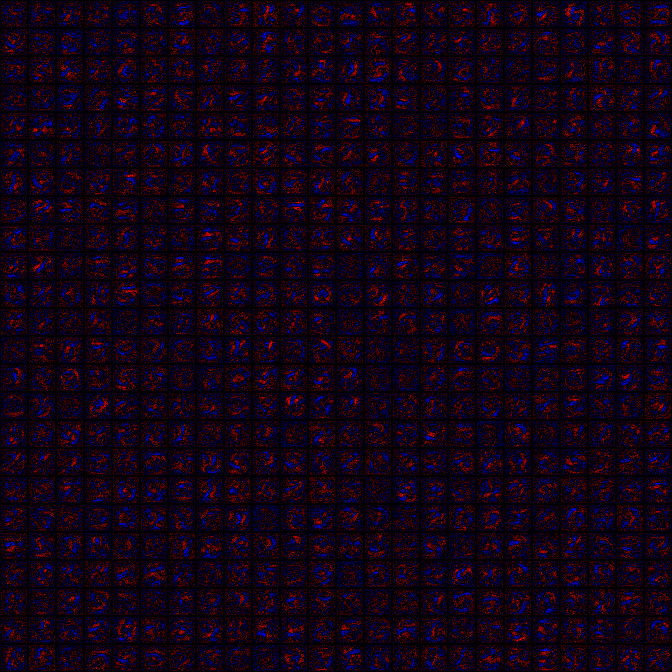

In [114]:
from andn.util.andn_visual_helpers import grayscale_to_red_and_blue
target_image = torch.zeros([clustering_dim * (img_size + 2), clustering_dim * (img_size + 2)])
weights = model.fc1.weight.data.clone()
weights /= weights.abs().max()

for i in range(clustering_dim):
    for j in range(clustering_dim):
        target_image[
            i * (img_size + 2) + 1:i * (img_size + 2) + img_size + 1,
            j * (img_size + 2) + 1:j * (img_size + 2) + img_size + 1
        ] = weights[i*clustering_dim+j].reshape(img_size, img_size).unsqueeze(0)

img = grayscale_to_red_and_blue(target_image.unsqueeze(0))
img = to_pil_image(img * 2)
img.resize(
    [clustering_dim * 28, clustering_dim * 28], Image.NEAREST
)